In [1]:
import tensorflow as tf
from imutils import paths
import os
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2, VGG16, ResNet50V2, Xception

In [2]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images('dataset'))
data = []
labels = []

[INFO] loading images...


In [3]:
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [4]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [5]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=layers.Input(shape=(224, 224, 3)))

for layer in baseModel.layers:
	layer.trainable = False

In [6]:
model = tf.keras.models.Sequential([
    baseModel,
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(2, activation='softmax')
])

In [7]:
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                1003536   
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 34        
Total params: 3,261,554
Trainable params: 1,003,570
Non-trainable params: 2,257,984
_________________________________________________________________


In [8]:
H = model.fit(trainX, trainY, batch_size=32, validation_split=0.2, epochs=20)

Epoch 1/20
10/10 [==============================] - 14s 1s/step - loss: 1.5776 - accuracy: 0.7000 - val_loss: 0.3832 - val_accuracy: 0.9375
Epoch 2/20
10/10 [==============================] - 1s 66ms/step - loss: 0.3958 - accuracy: 0.9563 - val_loss: 0.3618 - val_accuracy: 0.9875
Epoch 3/20
10/10 [==============================] - 1s 63ms/step - loss: 0.3502 - accuracy: 0.9781 - val_loss: 0.3540 - val_accuracy: 0.9875
Epoch 4/20
10/10 [==============================] - 1s 63ms/step - loss: 0.3366 - accuracy: 0.9844 - val_loss: 0.3715 - val_accuracy: 0.9375
Epoch 5/20
10/10 [==============================] - 1s 63ms/step - loss: 0.3292 - accuracy: 0.9750 - val_loss: 0.2945 - val_accuracy: 0.9875
Epoch 6/20
10/10 [==============================] - 1s 64ms/step - loss: 0.2360 - accuracy: 0.9750 - val_loss: 0.1185 - val_accuracy: 0.9750
Epoch 7/20
10/10 [==============================] - 1s 63ms/step - loss: 0.1694 - accuracy: 0.9875 - val_loss: 0.1605 - val_accuracy: 0.9875
Epoch 8/20
10/

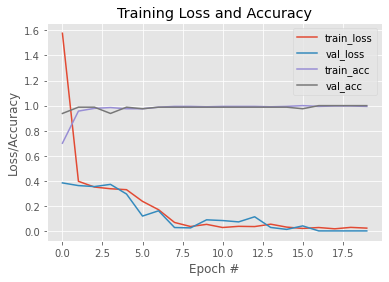

In [9]:
# plot the training loss and accuracy
N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig("learning_curve.png")

In [10]:
model.save("catdognet_transfer.h5")

In [11]:
# make predictions on the testing set
print("[INFO] evaluating network...")
model.evaluate(testX, testY)

[INFO] evaluating network...
4/4 [==============================] - 14s 4s/step - loss: 0.5265 - accuracy: 0.9400


[0.5265133380889893, 0.9399999976158142]

In [12]:
model(testX[2:3])

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[6.216353e-10, 1.000000e+00]], dtype=float32)>

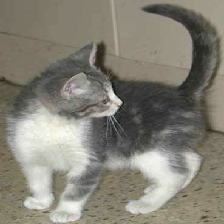

In [13]:
array_to_img(trainX[0])

In [14]:
trainY[0]

array([1., 0.], dtype=float32)

In [15]:
# test on new image
image = load_img('sample_image/5.jpg', target_size=(224, 224))
image = img_to_array(image)
image = preprocess_input(image)

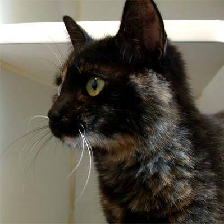

In [16]:
array_to_img(image)

In [17]:
image.shape

(224, 224, 3)

In [18]:
prediction = model(image.reshape(-1,224,224,3))

In [19]:
np.argmax(prediction, axis=1)

array([0])